# COGS 118B - Final Project

In [36]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Unlocking Fantasy Football: An Unsupervised Learning Analysis

## Group members

- Christopher Tams
- Vi Phan
- Dayoung Ki
- Eric Dong

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

American football is one of the world's most popular sports, with millions of fans tuning in to see their favorite players compete in an exciting game. The National Football League, or NFL, as it is more widely known, is the most well-known American football league. The NFL season culminates with the annual Super Bowl, which attracts a large audience every year<a name="operationnote"></a>[<sup>1</sup>](#operation). While the players on the field may be the only ones throwing or catching the ball, they are not the only ones participating in a game. As fans watch the action on the field, another form of engagement has emerged: fantasy football. Fantasy football allows football fans to create virtual teams, draft real NFL players, and compete using performance statistics. As the 2023 season has now concluded, fans are frantically analyzing player statistics to determine which players would be the best to draft for their 2024 fantasy football teams. This project aims to help fantasy football fans determine their draft picks by grouping players with similar stats. The use of AI to help fans with their fantasy football leagues is not a novel concept. Gridiron AI, a popular app, uses data analysis to help users make the best draft picks<a name="NFLAInote"></a>[<sup>2</sup>](#NFLAI). However, unlike Gridiron AI, our project will take a more diverse approach by investigating a different statistical model and will not be locked behind a paywall. 

# Problem Statement

The objective of this project is to develop a K-means algorithm to predict the potential standout performers for the upcoming NFL season. The datasets we will be using for this project utilize biological features and past performance statistics of the players. This dataset will be segmented into subsets based on their positions, and K-means algorithms will be training each subset to create clusters, grouping players according to their statistics. We will generate random clusters of players based on their attributes to evaluate the performance of the K-means. We will also apply the adjusted rand score to determine if it is able to accurately cluster players based on their attributes. This prediction is measurable since we can evaluate the accuracy of the K-means’ predictions by comparing them to fantasy football standings and random predictions. The adjusted rand score provides a quantitative measure of its performance in clustering players’ statistics. Lastly, because this process can be iterated in different NFL seasons using the similar datasets and method, this is replicable.

# Data

There is a lot of big data revolving around the NFL, so finding relevant data wasn’t hard. Although there was a lot of places to choose from, we ended up narrowing down to three data sources: 

**NFL Team Data 2003-2023**<a name="Cantalupanote"></a>[<sup>3</sup>](#Cantalupa):
This data set consists of 35 variables and 320 observations. The variables revolve around the overall yearly performance of each individual NFL team for the past 20 years. These describe features like number of wins/losses, the number of touchdowns, and average yards per play. All of the variables besides team name and year are quantitative variables that are describing either the total number of something happening (like wins and losses) or the average number of something gained/lost(like rushing yards per attempt). Because of this all of the observations, besides the name of the team, are represented by an int or float. The data is as clean as it is, so there wasn’t a need to do any special handling/cleaning. 


**NFL Player Statistic dataset**<a name="Steussienote"></a>[<sup>4</sup>](#Steussie):
This data set is a lot bigger than the others and is divided into many different parts. We chose to focus primarily on the combine portion of the dataset. This data revolves around each individual player's biological features and athletic capabilities. The data set has 35 variables and 9814 observations. Each observation has a mix of int, floats, and strings. The variables that have strings consist of either the name of the player, name of team, name of college, position of the player, or name of home city. The other variables consist of measurements in inches(like arm length), pounds(like weight or bench press), and seconds(like 40 meter dash). The data already came really clean so there was not much that we needed to adjust. 


**Pro-Football Reference**<a name="profootballnote"></a>[<sup>5</sup>](#profootball):
Pro-Football Reference holds a lot of statistical data from NFL player performance throughout the many decades of the NFL. To collect this data, we decided to Web Scrape using pandas built in function pd.read_html(url). This allowed us to seamlessly collect NFL data for individual players ranging from the years 2003-2022. The url for the different positions and years are very predictable so using a simple for loop that changed the url each time to reflect the year and position of players we were looking for was simple.


Once we got all of the data, we concated them into three different data frames, named passing, rushing, and receiving. The dimensions of these data frames were (1475, 31), (2671, 15), and (4020, 19) respectively.

We then added all of the team and combine data to each NFL player's respective row. After incorporating the combine data 30%, 43%, and 51% of players had been dropped from the passing, rushing, and receiving data frames due to insufficient data from the combine. We didn't have to drop any players after incorporating the team data. 

We then went through the columns of the passing, rushing, and receiving to take out unnecessary data like "High School Name". After, we went through the columns again to drop those who had more than 5% of their values NaN. Those who had less than 5% NaN but more than 0% had their NaN replaced with the average of the column. We then Web Scraped from Pro-Football Reference one more time to get each NFL player's Fantasy Football Rankings and insert them into their respective rows in the passing, rushing, and receiving dataframes. 

Finally, we normalized all of the columns using Z-score normalization and exported the dataframes as Cleaned_Passing, Cleaned_Rushing, and Cleaned_Receiving. The final dimensions for these data frames were (1173, 66), (1692, 54), (2296, 57) respectively.

In [2]:
Passing = pd.read_csv('Data_Wrangle/data/Cleaned_Passing.csv')
Rushing = pd.read_csv('Data_Wrangle/data/Cleaned_Rushing.csv')
Receiving = pd.read_csv('Data_Wrangle/data/Cleaned_Receiving.csv')

In [3]:
Receiving.columns

Index(['Player', 'Tm', 'Age', 'G', 'GS', 'Tgt', 'Rec', 'Yds', 'Y/R', 'TD',
       '1D', 'Succ%', 'Lng', 'Y/Tgt', 'R/G', 'Y/G', 'Fmb', 'Year', 'combineId',
       'playerId', 'combineYear', 'combineHeight', 'combineWeight',
       'collegeId', 'heightInches', 'weight', 'ageAtDraft', 'team_wins',
       'team_losses', 'team_win_loss_perc', 'team_points', 'team_points_opp',
       'team_points_diff', 'team_g', 'team_total_yards', 'team_plays_offense',
       'team_yds_per_play_offense', 'team_turnovers', 'team_fumbles_lost',
       'team_first_down', 'team_pass_cmp', 'team_pass_att', 'team_pass_yds',
       'team_pass_td', 'team_pass_int', 'team_pass_net_yds_per_att',
       'team_pass_fd', 'team_rush_att', 'team_rush_yds', 'team_rush_td',
       'team_rush_yds_per_att', 'team_rush_fd', 'team_penalties',
       'team_penalties_yds', 'team_pen_fd', 'team_score_pct',
       'team_turnover_pct', 'team_exp_pts_tot', 'Next_Year_PosRank'],
      dtype='object')

# Proposed Solution

One potential solution to the problem of assisting fantasy football fans in making draft picks is to use a clustering algorithm to group players with similar stats. We wanted to specifically focus on using the K-means algorithm using each player’s statistical profile that can be inputted into the algorithm. We can use Python’s scikit-learn library to perform the K-means clustering. After the clusters are created, fantasy football fans can use the clusters to create their draft picks. For example, if two players are in the same cluster, it indicates that they have similar statistical profiles and may be interchangeable in fantasy value. If a player is selected, team owners can use the clusters to look for players who are statistically similar to the first player. We intended to evaluate our model's accuracy by looking at the adjusted rand score. We also intended to compare the outcomes of our model with the actual 2023 fantasy football league player performance (according to ESPN)<a name="ESPNnote"></a>[<sup>6</sup>](#ESPN).  

# Evaluation Metrics

Given that we wanted to cluster our dataset using the K-means algorithm to look at the different statistics of Football players of the 2023 NFL season, the evaluation metric we wanted to focus on was assessing the cluster qualities we have and see how well the algorithm fits our data in proper clusters. In addition, we wanted to focus on being able to interpret the results well given the different clusters. 
One of the evaluation metrics we wanted to focus on is the adjusted rand score, which compares the similarities between the predicted clusters the data is put into versus the actual clusters they belong to. The adjusted random index also takes into account the possibility of chance, making it more accurate as a measure than the random index. The adjusted random index is calculated by: ARI = (RI - Expected_RI) / (max(RI) - Expected_RI). However, given that there is no accurate way to say which actual cluster the datasets belong to other than our human eye judgment, we also wanted to use other evaluation metrics.
Another evaluation metric we wanted to look at was the Elbow graphing method as well, a way to find the optimal K value for our K-means algorithm. This method graphs the Within-Cluster Sum of Squares, which really just gets the sum of the square distances between the points in the cluster and the cluster center. Then, we can look at the graph and see where the WCSS value starts to flatten out as the number of clusters increases.

# Results

What we are aiming to do throughout this entire report is create an algorithm to group players based on statistical similarity, which will enable insightful analysis for team management and strategic decision-making in American football.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Results

What we are aiming to do throughout this entire report is create an algorithm to group players based on statistical similarity, which will enable insightful analysis for team management and strategic decision-making in American football.

### K-Means Feature Selection

During the feature selection phase of our clustering task using football statistics datasets, we meticulously recognized and extracted critical performance metrics related to football players' passing, running, and receiving skills. We selected a wide range of statistics that together represent the complex skill sets displayed on the field, based on our thorough knowledge of football dynamics. These metrics range from basic passing accuracy to complex running and receiving proficiency measures. We aim to create informative clusters that represent the diverse roles and contributions of players in different aspects of the game by carefully choosing features that capture different facets of player performance. This careful feature selection procedure serves as the foundation for our next use of the KMeans algorithm, which is expected to provide insightful information for strategic planning and football management.


In [26]:
passing_features = Passing[['Cmp', 'Att','Cmp%','Yds','TD','Int','Y/A']]
receiving_features = Receiving[['Tgt','Rec','Yds','TD','Succ%','R/G','Y/G']]
rushing_features = Rushing[['Att','Yds','TD','1D','Succ%','Y/A','Y/G']]

We should also determine what k value is the most appropriate for our data. To do this, we used the elbow method.

Text(0.5, 1.0, 'Distortion Measures of Passing Features')

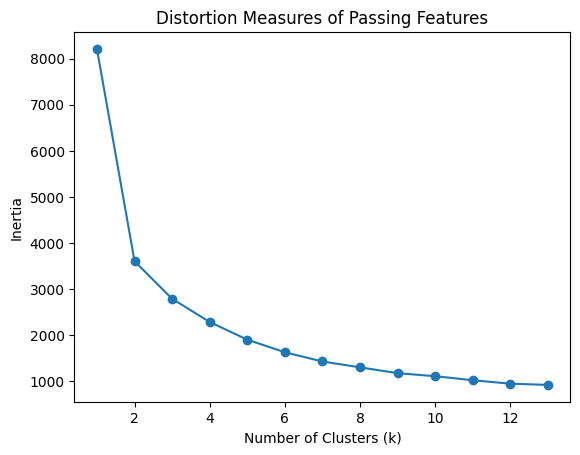

In [27]:
# Passing Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(passing_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Passing Features')

Text(0.5, 1.0, 'Distortion Measures of Receiving Features')

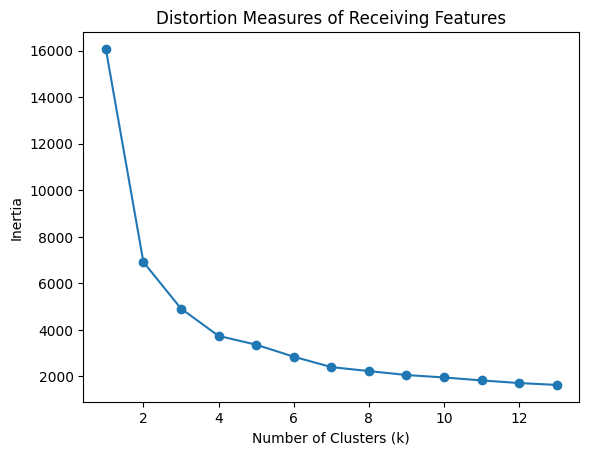

In [28]:
# Receiving Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(receiving_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Receiving Features')

Text(0.5, 1.0, 'Distortion Measures of Rushing Features')

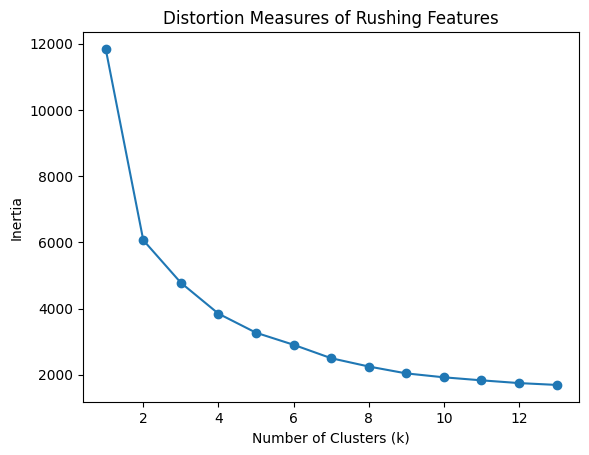

In [29]:
# Rushing Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(rushing_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Rushing Features')

As we can see from the plot, according to our dataset and the elbow method where the graph starts to level off, the optimal number of clusters for all 3 datasets seem to be around 5. 

In [30]:
optimal_k = 5

### Why A K-means algorithm?

Because of the K-means algorithm's ease of use, scalability, and interpretability, we decided to use it in our project to group football players according to statistical similarity. Because K-means is easy to implement and computationally efficient, it provides an effective way to organize large datasets of player statistics. It is especially useful for analyzing various player performance metrics due to its flexibility in determining the ideal number of clusters and suitability for numerical data. K-means is a practical and effective option for our project's clustering objectives, despite its limitations, which include sensitivity to initial centroids and spherical cluster bias. These advantages, along with its simplicity, scalability, and interpretability, make it an appealing option.

In [31]:
# this one also has a huge error after

kmeans_passing = KMeans(n_clusters=optimal_k, n_init='auto')
kmeans_receiving = KMeans(n_clusters=optimal_k, n_init='auto')
kmeans_rushing = KMeans(n_clusters=optimal_k, n_init='auto')

kmeans_passing.fit(passing_features.values)
kmeans_receiving.fit(receiving_features.values)
kmeans_rushing.fit(rushing_features.values)

KMeans(n_clusters=5, n_init='auto')

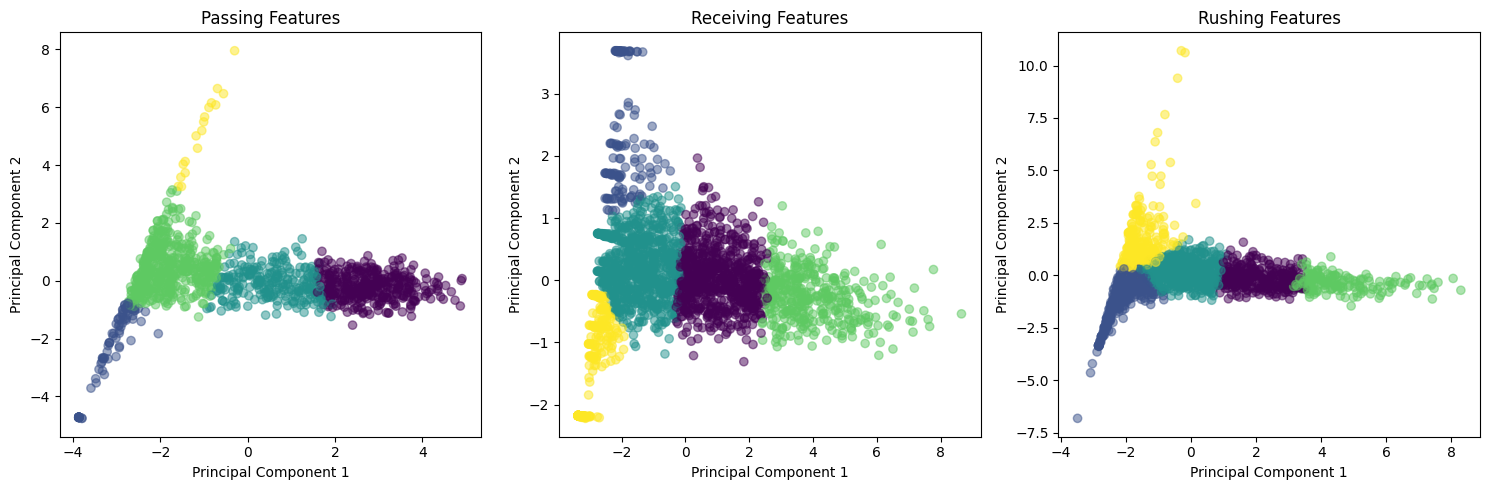

In [32]:
# uuuh idk if this is right or not
pca = PCA(n_components=2)
passing_pca = pca.fit_transform(passing_features)
receiving_pca = pca.fit_transform(receiving_features)
rushing_pca = pca.fit_transform(rushing_features)
plt.figure(figsize=(15, 5))

# Plot for passing dataset
plt.subplot(1, 3, 1)
plt.scatter(passing_pca[:, 0], passing_pca[:, 1], c=kmeans_passing.labels_, cmap='viridis', alpha=0.5)
plt.title('Passing Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# Plot for receiving dataset
plt.subplot(1, 3, 2)
plt.scatter(receiving_pca[:, 0], receiving_pca[:, 1], c=kmeans_receiving.labels_, cmap='viridis', alpha=0.5)

plt.title('Receiving Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot for rushing dataset
plt.subplot(1, 3, 3)
plt.scatter(rushing_pca[:, 0], rushing_pca[:, 1], c=kmeans_rushing.labels_, cmap='viridis', alpha=0.5)
plt.title('Rushing Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

### Re-Evalulating our Model

Despite K-means being so easy to ease and computationally efficient, we see that K-means does not do an amazing job of clustering our data, especially as our data doesn't fit well into spherical clusters. Thus, the limitations of K-means seem to outweigh the benefits in this case. Thus, we wanted to take a look at another option to model our data and look for a way to cluster the players in groups that will make it clear how desirable they might be for fantasy football. 

### Gaussian Mixture Model (GMM) - Feature Selection

We decided to go with the Gaussian Mixture Model for our dataset, hopefully capturing more of the clusters we see that are not spherical and overlap. This is because the GMM is better for capturing data points falling into various clusters as well as various shapes and sizes, rather than the spherical nature of K-means. In addition, as there are an unknown number of clusters, there are criterion for determining the number of clusters, such as BIC and AIC. Thus to begin, we will plot the BIC and AIC for a variety of `n_components` to find the ideal number of clusters. In this case, when we plot the the BIC and AIC, we are still looking for the Elbow in the curve to find the ideal number of clusters. 

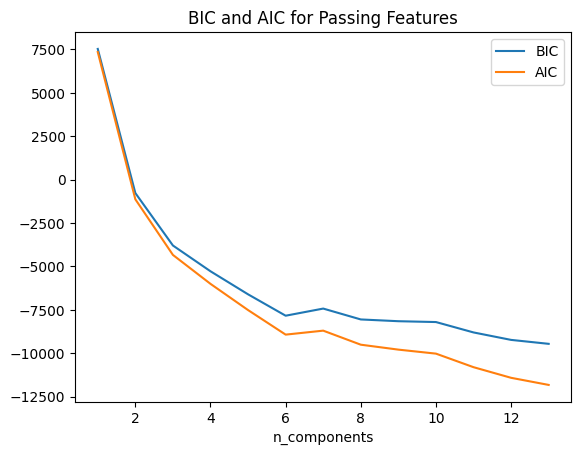

In [43]:
# Determining the amount of n_components for passing features

n_components = np.arange(1, 14)
models = [GaussianMixture(n, random_state=0).fit(passing_features.values) for n in n_components]

plt.plot(n_components, [m.bic(passing_features.values) for m in models], label='BIC')
plt.plot(n_components, [m.aic(passing_features.values) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC and AIC for Passing Features')
plt.show()

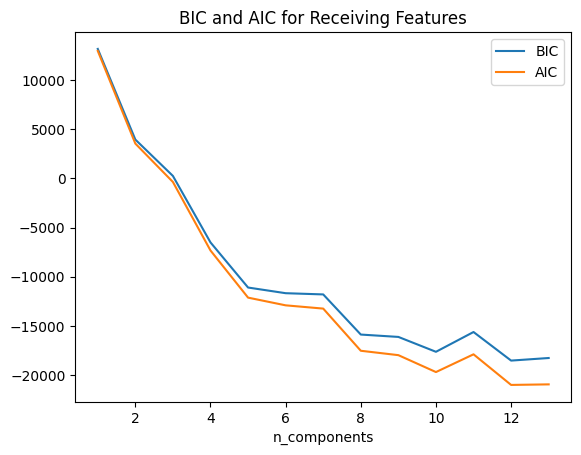

In [47]:
# Determining the amount of n_components for receiving features

n_components = np.arange(1, 14)
models = [GaussianMixture(n, random_state=0).fit(receiving_features.values) for n in n_components]

plt.plot(n_components, [m.bic(receiving_features.values) for m in models], label='BIC')
plt.plot(n_components, [m.aic(receiving_features.values) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC and AIC for Receiving Features')
plt.show()

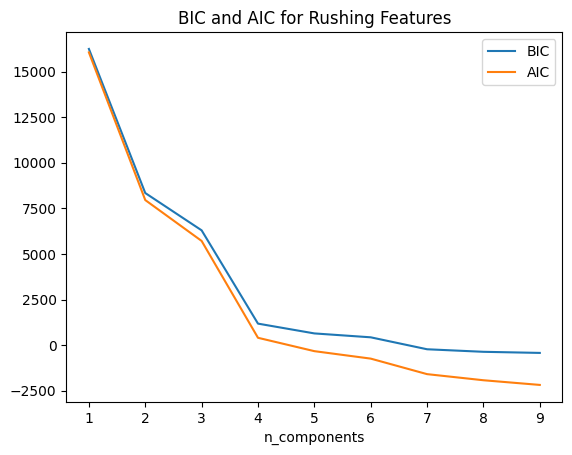

In [70]:
# Determining the amount of n_components for rushing features

n_components = np.arange(1, 10)
models = [GaussianMixture(n, random_state=0).fit(rushing_features.values) for n in n_components]

plt.plot(n_components, [m.bic(rushing_features.values) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rushing_features.values) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC and AIC for Rushing Features')
plt.show()

As we can see, all 3 of Passing, Receiving, and Rushing have BIC and AIC that are pretty similar; however the elbow points seem to be different for each different dataset. Thus, for Passing we see that approximately 6 clusters seems ideal. However, for Receiving, it seems like the graph levels out closer to 8 clusters. Finally, for the Rushing graph, we see that the BIC and AIC curves have a clear elbow around `n_components = 4`. 

In [78]:
n_comp_pass = 6
n_comp_receive = 8
n_comp_rush = 4

# Random State for reproducibility
random_s = 123

# Creating and fitting the GMM for each dataset
gmm_pass = GaussianMixture(n_components=n_comp_pass, random_state=random_s, covariance_type='full').fit(passing_features.values)
gmm_receive = GaussianMixture(n_components=n_comp_receive, random_state=random_s, covariance_type='full').fit(receiving_features.values)
gmm_rush = GaussianMixture(n_components=n_comp_rush, random_state=random_s, covariance_type='full').fit(rushing_features.values)


### Graphing our GMM

Now that we have our models fitted, we want to see what the GMM looks like, and see if it fits our data well.

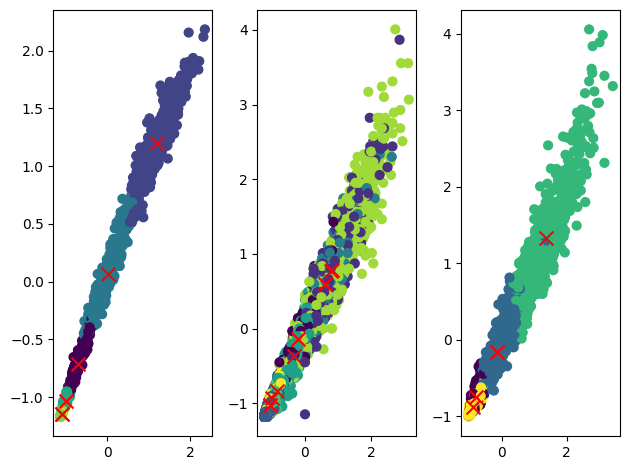

In [84]:
# Passing Dataset
labels = gmm_pass.predict(passing_features.values)
centroids = gmm_pass.means_

plt.subplot(1, 3, 1)
plt.scatter(passing_features.values[:, 0], passing_features.values[:, 1], c=labels, s=40, cmap='viridis')

# Plot cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')


# Receiving Dataset
labels = gmm_receive.predict(receiving_features.values)
centroids = gmm_receive.means_

plt.subplot(1, 3, 2)
plt.scatter(receiving_features.values[:, 0], receiving_features.values[:, 1], c=labels, s=40, cmap='viridis')

# Plot cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')


# Rushing Dataset
labels = gmm_rush.predict(rushing_features.values)
centroids = gmm_rush.means_

plt.subplot(1, 3, 3)
plt.scatter(rushing_features.values[:, 0], rushing_features.values[:, 1], c=labels, s=40, cmap='viridis')

# Plot cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')


plt.tight_layout()
plt.show()

### Evaluating our K-Means Model: Sihlouette Score

In order to evaluate our results from the Kmeans algorithm, we used a Sihloutte Score. A Silhouette Score would allow us to see how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [33]:
passing_silhouette_avg = silhouette_score(passing_features, kmeans_passing.labels_)
print("Passing Silhouette Score:", passing_silhouette_avg)

receiving_silhouette_avg = silhouette_score(receiving_features, kmeans_receiving.labels_)
print("Receiving Silhouette Score:", receiving_silhouette_avg)

rushing_silhouette_avg = silhouette_score(rushing_features, kmeans_rushing.labels_)
print("Rushing Silhouette Score:", rushing_silhouette_avg)

Passing Silhouette Score: 0.36648551712594934
Receiving Silhouette Score: 0.34192963425180734
Rushing Silhouette Score: 0.27374574830228754


As we can see from the results of our Silhouette scores, our KMeans clusters have similar silhouette scores, but none are too low or high. This suggests cohesive structures and clusters, but nothing very strong with very meaningful results.
For Passing, the clusters formed by applying KMeans to the passing features have a Silhouette Score of approximately 0.366. For receiving, we received a score of 0.342. These are both higher than Rushing, where we received a score of 0.274. 

### Evaluating our K-Means Model: Adjusted Rand Score

Alongside our sihlouette score, we also wanted to use an adjusted rand score to see how accurate our model is. 

In [ ]:
# insert adjusted rand score algorithm here. idk how to do it 

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

- The data files that our group used are publicly available on Kaggle and Pro Football Reference, which are publicly accessible sites.
- The players’ information and contracts are also available publicly online. Their contracts cannot be kept private due to the league to enforce salary cap requirements. 
- The potential bias that may have occurred when collecting the data:
    - Players who have fame or recognition are typically expected to maintain a high level of proficiency.
    - Players who newly joined the league typically characterized by lower salaries, also often viewed as still developing their skills.
    - Players with high salaries are expected to justify their compensation through high quality on-field contributions.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="operationnote"></a>1.[^](#operation): *Super Bowl LVIII is most-watched telecast in history: NFL Football Operations.* Super Bowl LVIII is Most-Watched Telecast in History | NFL Football Operations. (2024a, February 13). https://operations.nfl.com/updates/the-game/super-bowl-lviii-is-most-watched-telecast-in-history/<br> 
<a name="NFLAInote"></a>2.[^](#NFLAI): *NFL Artificial Intelligence, Analytics, & Statistics.* Gridiron AI. (n.d.). https://gridironai.com/football/<br> 
<a name="Cantalupa"></a>3.[^](#Cantalupa): Cantalupa, N. (2024, January 17). *NFL team data 2003-2023.* Kaggle. https://www.kaggle.com/datasets/nickcantalupa/nfl-team-data-2003-2023<br>
<a name="Steussienote"></a>4.[^](#Steussie): Steussie, T. (2020, April 27). *NFL play Statistics Dataset (primary).* Kaggle. https://www.kaggle.com/datasets/toddsteussie/nfl-play-statistics-dataset-2004-to-present?select=combine.csv<br> 
<a name="profootballnote"></a>5.[^](#profootball): *2023 NFL rushing.* Pro. (n.d.). https://www.pro-football-reference.com/years/2023/rushing.htm<br> 
<a name="ESPNnote"></a>6.[^](#ESPN): ESPN Internet Ventures. (n.d.). *Fantasy football scoring leaders.* ESPN. https://fantasy.espn.com/football/leaders<br> 